Embeddings shape: (118, 1000)


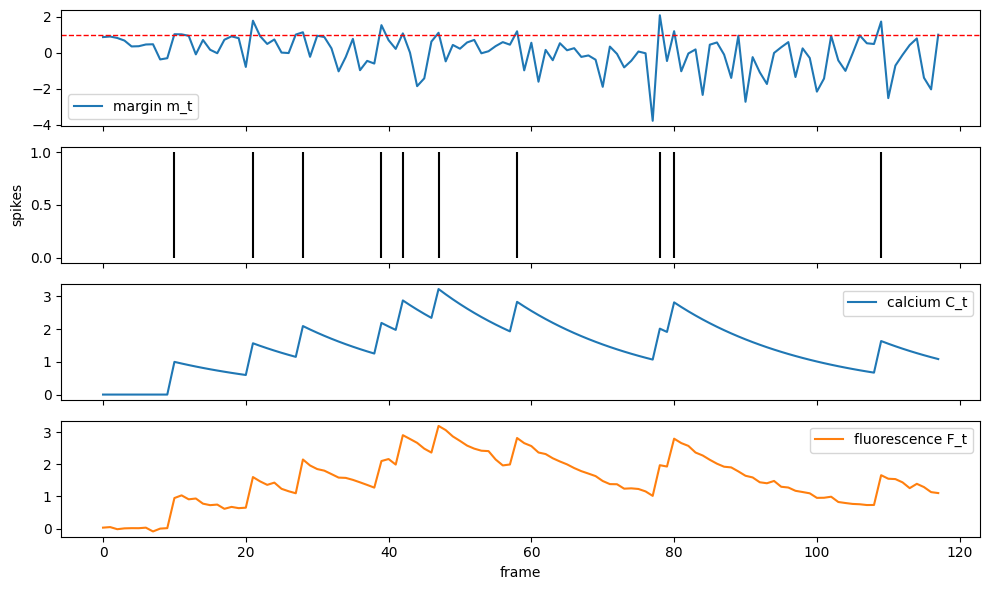

In [4]:
import numpy as np
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt

# === Load ViT embeddings ===
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

# Convert to a matrix (assumes vit_dict is {image_id: logits})
embeddings = np.stack(list(vit_dict))   # shape: (N_images, n_classes)
print("Embeddings shape:", embeddings.shape)

# Compute softmax over classes (object probabilities)
X = softmax(embeddings, axis=1)

# Normalize features
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

# === Define a single neuron model ===
np.random.seed(0)
n_features = X.shape[1]
w = np.random.randn(n_features)  # neuron’s “feature sensitivity”
w /= np.linalg.norm(w)

# Compute margin projection (stimulus drive)
m = X @ w
m = (m - m.mean()) / m.std()  # normalize

# === Spike generation: margin crossing ===
theta = 1.0     # threshold
refractory = 1  # minimal interval (in frames)
spikes = np.zeros_like(m, dtype=bool)

for t in range(1, len(m)):
    if m[t] > theta and not np.any(spikes[max(0, t-refractory):t]):
        spikes[t] = True

# === Calcium dynamics ===
T = len(m)
C = np.zeros(T)
A = 1.0      # calcium jump per spike
gamma = 0.95 # decay per frame
for t in range(1, T):
    C[t] = gamma * C[t-1] + A * spikes[t]

# === Fluorescence (noisy observation) ===
noise_std = 0.05
F = C + np.random.normal(0, noise_std, size=T)

# === Plot ===
fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
ax[0].plot(m, label='margin m_t')
ax[0].axhline(theta, color='r', ls='--', lw=1)
ax[0].legend()
ax[1].stem(spikes.astype(int), linefmt='k-', markerfmt=' ', basefmt=' ')
ax[1].set_ylabel('spikes')
ax[2].plot(C, label='calcium C_t', color='tab:blue')
ax[2].legend()
ax[3].plot(F, label='fluorescence F_t', color='tab:orange')
ax[3].legend()
ax[3].set_xlabel('frame')
plt.tight_layout()
plt.show()


In [8]:
!pip install --no-deps oasis
!pip install scikit-learn tables


  Using cached tables-3.10.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached tables-3.10.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 16.2 MB/s eta 0:00:00
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.2/546.2 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
oasis 0.1.3 requires sklearn, which is not installed.


In [9]:
# deconvolve_oasis.py
import numpy as np
from typing import Tuple, Optional

# OASIS v1 API
from oasis.functions import deconvolve

def estimate_ar1_from_tau(tau_sec: float, fps: float) -> float:
    """
    Convert a calcium decay time constant tau (seconds) to AR(1) coefficient g.
    g = exp(-dt/tau).  For GCaMP6f, tau ~ 0.4–0.7 s is common; adjust per prep.
    """
    dt = 1.0 / fps
    return float(np.exp(-dt / max(tau_sec, 1e-6)))

def deconvolve_fluorescence_oasis(
    F: np.ndarray,
    fps: float,
    tau_sec: Optional[float] = None,
    g: Optional[float] = None,
    lam: float = 0.0,
    s_min: float = 0.0,
    detrend_percentile: float = 8.0,
    event_z: float = 2.0,
) -> Tuple[np.ndarray, np.ndarray, float, float, float, np.ndarray]:
    """
    Deconvolve a 1D fluorescence trace with OASIS (AR(1) model).

    Args
    ----
    F : array, shape (T,)
        Fluorescence (already neuropil-corrected & motion-corrected if applicable).
    fps : float
        Sampling rate (Hz).
    tau_sec : float, optional
        Calcium decay time constant. If given, we set g = exp(-dt/tau).
    g : float, optional
        AR(1) coefficient. If both tau_sec and g are None, we let OASIS estimate it.
    lam : float
        Sparsity penalty (lambda); 0.0 is a decent default for a first pass.
    s_min : float
        Minimum spike size constraint.
    detrend_percentile : float
        Baseline percentile for coarse detrending (helps with slow drift).
    event_z : float
        Z-score threshold on s to produce discrete events.

    Returns
    -------
    c : inferred denoised calcium trace (same length as F)
    s : inferred nonnegative spike-rate trace
    b : inferred baseline
    g_est : AR(1) coefficient used/estimated
    lam_est : lambda used/estimated
    events_idx : indices of detected discrete events (np.ndarray of ints)
    """
    F = np.asarray(F, dtype=np.float64).copy()
    T = F.size

    # Coarse baseline detrend (optional but robust)
    base = np.percentile(F, detrend_percentile)
    Fd = F - base

    # Choose AR(1) parameter
    if g is None and tau_sec is not None:
        g = estimate_ar1_from_tau(tau_sec, fps)

    # Run OASIS
    # If g is None, OASIS will estimate it (and baseline) from the data.
    c, s, b, g_est, lam_est = deconvolve(
        Fd, g=g, penalty=1, lam=lam, s_min=s_min
    )

    # Add baseline back to c for convenience
    c = c + base
    b = b + base

    # Turn s (continuous rate) into discrete events with a simple adaptive threshold
    # Robust z-score on s:
    s_mu = np.median(s)
    s_sigma = np.median(np.abs(s - s_mu)) * 1.4826 + 1e-12
    z = (s - s_mu) / s_sigma
    events_idx = np.where(z > event_z)[0]

    return c, s, float(b), float(g_est), float(lam_est), events_idx

if __name__ == "__main__":
    # Tiny demo with a synthetic AR(1) + spikes (replace with your F)
    import matplotlib.pyplot as plt

    rng = np.random.default_rng(0)
    T, fps = 2000, 30.0
    true_tau = 0.6
    g_true = np.exp(-(1/fps)/true_tau)
    C = np.zeros(T)
    spikes_true = (rng.random(T) < 0.01).astype(float)
    for t in range(1, T):
        C[t] = g_true * C[t-1] + 1.0 * spikes_true[t]
    F = C + 0.05 * rng.standard_normal(T) + 0.1  # add noise + baseline

    c, s, b, g_est, lam_est, idx = deconvolve_fluorescence_oasis(
        F, fps=fps, tau_sec=0.6, event_z=2.5
    )
    print(f"Estimated g: {g_est:.3f} (true {g_true:.3f}), baseline ~ {b:.3f}, lambda {lam_est:.3g}")
    print(f"Detected {len(idx)} events")

    fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    ax[0].plot(F, lw=1, label="F (raw)")
    ax[0].plot(c, lw=1, label="c (denoised)")
    ax[0].legend(loc="upper right")
    ax[1].plot(s, lw=1, label="s (OASIS)")
    ax[1].legend(loc="upper right")
    ax[2].stem(idx, np.ones_like(idx), basefmt=" ", linefmt="k-", markerfmt=" ", use_line_collection=True)
    ax[2].set_ylabel("events")
    ax[2].set_xlabel("frame")
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'oasis.functions'